In [ ]:
#Que1 (d) and (e) and (g) Features selection, top of the model built up in part d, and ROC
#Run Command: python training_file testing_file setmming/lemmatization e/d(question no.)

In [20]:
#import all libraries here
import pandas as pd
import re 
from tqdm import tqdm
import math
from random import *
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
import sys

In [3]:
# p1 = sys.argv[1] #training file
# p2 = sys.argv[2] # testing file
# p3 = sys.argv[3] # stemming/lemmatization
# p4 = sys.argv[4] # option e or d
# p5 = sys.argv[4] # 2 or 3 for ngram
p1 = "trainingandtestdata/training.1600000.processed.noemoticon.csv" #training file
p2 = "trainingandtestdata/testdata.manual.2009.06.14.csv"  #testing file
p3 = "lemmatization"
p4 = "d"
p5 = 3

In [4]:
#Reading data from the given data file into data frames
#0th (label) and 5th(tweets) are only extracted from the file
def read_data(file_path):
    df = pd.read_csv(file_path,encoding='latin-1', usecols=[0,5], header=None)
    return df

In [5]:
df_data = read_data(p1)

In [6]:
#this function returns ngrams
def calc_ngrams(tweet_tokens,n):
    args = [tweet_tokens[i:] for i in range(n)]
    return list(zip(*args))

In [7]:
#create dictionary without stop words
def create_dict(df_input, no_samples, stem_type,option):
    freq_dict = {}
    list_of_tokens = []
    stopwords = nltk.corpus.stopwords.words('english')
    snowball = SnowballStemmer('english')
    lemma = WordNetLemmatizer()
    
    for tweet in tqdm(df_input):
        tweet_rm  = " ".join(filter(lambda x:x[0]!='@', tweet.split()))
        tweet_list = word_tokenize(tweet_rm)     
        lower_list = [word.lower() for word in tweet_list if word.isalpha()]
        no_punc_text= lower_list
        
              
        if stem_type == 'stemming':
            txt_clean = [ snowball.stem(x) for x in no_punc_text if x not in stopwords]
        
        if stem_type == 'lemmatization':
            txt_clean = [ lemma.lemmatize(x) for x in no_punc_text if x not in stopwords]
        
        
        #if the question que1 (e) then only bigrams will be considered
        #for the question que1 (d) only the unigrams will be considered
        if option == 'e':
            #ngrams are calculated here
            ngrams_list = calc_ngrams(txt_clean,p5)
            #Ngrams are taken together with unigram
            txt_clean = txt_clean + ngrams_list
        
        
        list_of_tokens.append(txt_clean)
        for word in txt_clean:
            if(word in freq_dict.keys()):
                freq_dict[word]+=1
            else:
                freq_dict[word]=1
            
    return list_of_tokens,freq_dict

In [8]:
#function to make two dictionaries one for each class 0 and 4
#it puts both dictionaries into a list and returns the list
#0 = negative, 4 = positive
def make_dictionaries(stem_type):
    
    df_neg_data = df_data[df_data[0] == 0][5].tolist()
    df_pos_data = df_data[df_data[0] == 4][5].tolist()
    
    prob_pos_class = (len(df_pos_data)/(len(df_neg_data) + len(df_pos_data) ))
    prob_neg_class = (len(df_neg_data)/(len(df_neg_data) + len(df_pos_data) ))
        
    
    list_of_neg_tokens,dict_neg_data = create_dict(df_neg_data,len(df_neg_data),stem_type,p4)
    list_of_pos_tokens,dict_pos_data = create_dict(df_pos_data,len(df_pos_data),stem_type,p4)
    
    list_freq = [dict_neg_data,dict_pos_data]
    list_tokens = list_of_neg_tokens + list_of_pos_tokens
    
    return list_freq,list_tokens,prob_pos_class,prob_neg_class
    

In [9]:
# list_freq,list_tokens,prob_pos_class,prob_neg_class = make_dictionaries('stemming')
list_freq,list_tokens,prob_pos_class,prob_neg_class = make_dictionaries(p3)
df_data['clean_data'] = list_tokens


100%|██████████| 800000/800000 [02:20<00:00, 5713.45it/s]


In [10]:
#It takes a dictionary as input and returns another dictionary with probability of each word
# no of times a word occur / total no. of words (frequencies are considered not the unique words)
# Laplace_Smoothing is done here itself
def calculate_probs(input_dict,X):
    dict_prob={}
    alpha = len(X)
    c = 1
    total_words = sum(input_dict.values())
    print('alpha :',alpha,total_words)
    for i in X:
        val = input_dict.get(i,0)
        dict_prob[i]=((val + c)/(total_words + c*alpha))
        
    return dict_prob
    

In [11]:
#function to return the list of probability dictionaries
def return_prob_dict():
    X = (set(list_freq[0]) | set(list_freq[1]))
    print('no of words :',len(X))
    dict_neg_prob = calculate_probs(list_freq[0],X)
    dict_pos_prob = calculate_probs(list_freq[1],X)
    list_prob = [dict_neg_prob, dict_pos_prob]
    
    return list_prob

In [12]:
list_prob= return_prob_dict()

no of words : 243175
alpha : 243175 5616544
alpha : 243175 5355205


In [13]:
#returns the list of words of a sentence
def return_tokens(tweet,option):
    stopwords = nltk.corpus.stopwords.words('english')
    tweet_rm  = " ".join(filter(lambda x:x[0]!='@', tweet.split()))
    tweet_list = word_tokenize(tweet_rm)
    lower_list = [word.lower() for word in tweet_list if word.isalpha()]
    txt_clean = [x for x in lower_list if x not in stopwords]
    
    
    if option == 'e':
        #bigrams are claculated here
        ngrams_list = calc_ngrams(txt_clean,p5)
        #ngrams and unigrams are taken together
        txt_clean = txt_clean + ngrams_list
    
    return txt_clean

In [14]:
#calculates P(new_tweet/-ve)
def cal_prob_neg_class(new_tweet,test_type):
    prob = 0;
    total_keys = len(list_prob[0])
    c = 1
    
    if test_type == 'test' :
        #option e or d as given input here
        list_of_words = return_tokens(new_tweet,p4)
    else :
        list_of_words = new_tweet
        
    for word in list_of_words:
        prob += math.log(list_prob[0].get(word,1/(c*total_keys)))
    return prob

In [15]:
#calculates P(new_tweet/+ve)
def cal_prob_pos_class(new_tweet,test_type):
    prob = 0;
    total_keys = len(list_prob[1])
    
    if test_type == 'test' :
        #option e or d as given input here
        list_of_words = return_tokens(new_tweet,p4)
    else :
        list_of_words = new_tweet
        
    c = 1
    for word in list_of_words:
        prob += math.log(list_prob[1].get(word,(c/(c*total_keys))))
    return prob

In [16]:
#predict the class of new tweet
def make_prediction(new_tweet,test_data):
    prob_new_tweet_given_pos_class = cal_prob_pos_class(new_tweet,test_data)
    prob_new_tweet_given_neg_class = cal_prob_neg_class(new_tweet,test_data)
    
    pos_class_prob = prob_new_tweet_given_pos_class + math.log(prob_pos_class)
    neg_class_prob = prob_new_tweet_given_neg_class + math.log(prob_neg_class)
    
    if pos_class_prob > neg_class_prob:
        return neg_class_prob,pos_class_prob,4
    else:
        return neg_class_prob,pos_class_prob,0

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
def calculate_accuracy(file_path,test_type):
    pred_list=[]
    class0_prb = []
    class4_prb = []
    
    if test_type == 'test':
        df_test_data = pd.read_csv(file_path,encoding='latin-1', usecols=[0,5], header=None)
        test_data = df_test_data[df_test_data[0] !=2]
        test_data.reset_index(drop=True, inplace=True)
        X = test_data[5]
    else :
        test_data = df_data
        X = test_data['clean_data']
        
    for i in tqdm(X):
        cls_prb0,cls_prb4,pred=make_prediction(i,test_type)
        pred_list.append(pred)
        class0_prb.append(cls_prb0)
        
        temp = np.exp(cls_prb4)/(np.exp(cls_prb4)+np.exp(cls_prb0))
        class4_prb.append(temp)
        
    test_data['pred']=pred_list
    conf_matrix = confusion_matrix(test_data[0],test_data['pred'])
    accuracy = len(test_data[test_data[0]==test_data['pred']])/len(test_data)
    
    if p4 == "d":
        test_data['label'] = test_data[0]
        test_data.loc[test_data['label'] == 4, 'label'] = 1
        test_data.loc[test_data['pred'] == 4, 'pred'] = 1

        nb_fpr4,nb_tpr4,threshold4 = roc_curve (test_data['label'],class4_prb,pos_label=1) 
        nb_auc4 = auc(nb_fpr4,nb_tpr4)

        plt.figure(figsize=(5,5),dpi=100)
        plt.plot(nb_fpr4,nb_tpr4,linestyle='-',color='darkorange',label='NB(auc=%0.2f)'%nb_auc4)
        plt.plot([0, 1], [0, 1], color='r', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="upper left")
        plt.show()
    
    return accuracy,conf_matrix
    

100%|██████████| 359/359 [00:00<00:00, 1835.38it/s]

--------Accuracies reported on the test and train data for d part--------


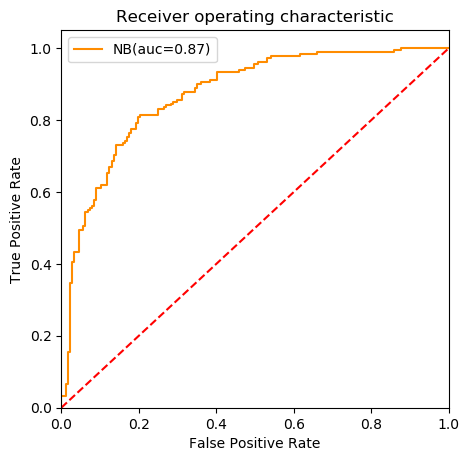

Accuracy on Test Data : 0.7855153203342619


In [33]:
print('--------Accuracies reported on the test and train data for '+p4+' part--------')
accuracy,conf_matrix = calculate_accuracy(p2,'test')
print('Accuracy on Test Data :',accuracy)
# print(conf_matrix)

100%|██████████| 1600000/1600000 [00:12<00:00, 132901.99it/s]


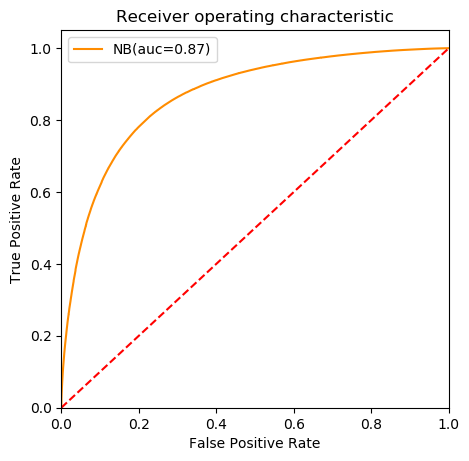

Accuracy on Training Data : 0.790635625
[[640748 159252]
 [175731 624269]]


In [34]:
accuracy,conf_matrix = calculate_accuracy(p3,'train')
print('Accuracy on Training Data :',accuracy)
print(conf_matrix)